# **Install Dependencies:**

 - Default version of fastai in Google Colab is 1.0.61(?), we need >v2.2.5

In [2]:
!pip install -Uqq fastai

In [3]:
import fastai
print(fastai.__version__)
PROJECT_NAME = "FastAI_PETS"
MODEL_NAME = "fastai_pets_breeds_001.pkl"

2.2.5


## **PETS Dataset**

Load the PETS dataset:

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

files = get_image_files(path/"images")
print("There are %s images" % (len(files)))

There are 7390 images


## **Build a Simple Model**

I played around with different DataBlock Transforms
- item_tfms=Resize(224)
- item_tfms=Resize(224, ResizeMethod.Squish)
- item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros')

These need to be revisited, but I went w/ ResizeMethod.Pad w/ aug_transform

I tried RESNET34 and RESNET101:
- RESNET101 w/ full precision float exhausted my 8GB Nvidia GTX1070ti memory, so had to use .to_fp16() to use half precision floats
- RESNET101 had a slight edge over RESNET34...but did start to show signs of over fitting

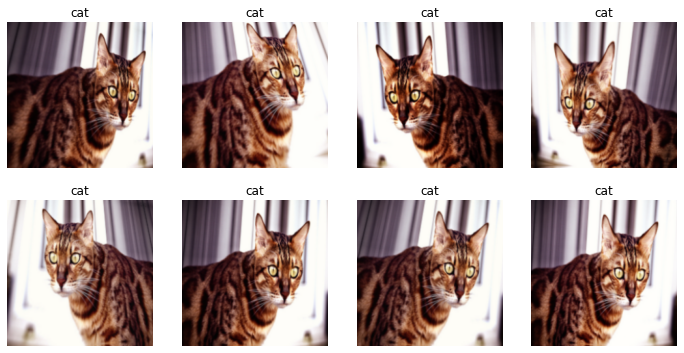

In [4]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 #item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
                 #item_tfms=Resize(224),
                 item_tfms=Resize(224, ResizeMethod.Squish),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(path/"images")
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [6]:
# Train Model with RESNET101 
learn = cnn_learner(dls, resnet101, metrics=error_rate).to_fp16()
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.881357,0.414210,0.126522,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.371813,0.435212,0.123816,01:30
1,0.385563,0.528404,0.146143,01:29
2,0.228978,0.311638,0.092693,01:29
3,0.109928,0.324267,0.086604,01:29
4,0.057424,0.292521,0.083221,01:29


**That's not terrble error rate: 8%**

Lets look at the confusion matrix and top losses:

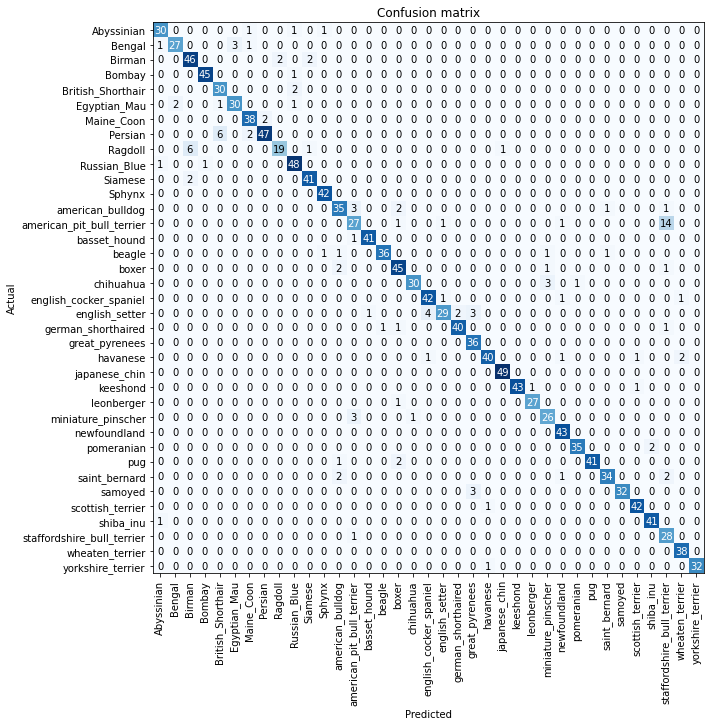

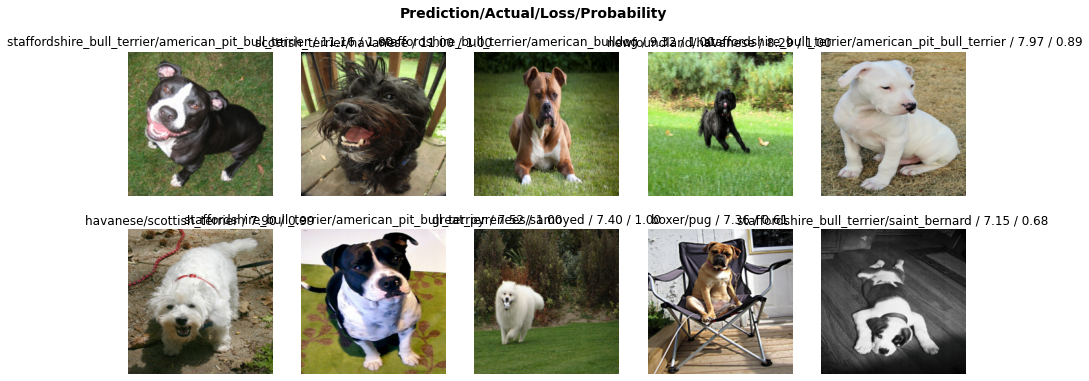

In [8]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.most_confused(min_val=5)
interp.plot_top_losses(10, nrows=2)

In [ ]:
# Free Memory from last model
del learn
torch.cuda.empty_cache()

## **Let's Tune the Learning Rate**

Minimum/10: 5.75e-03, steepest point: 1.45e-03


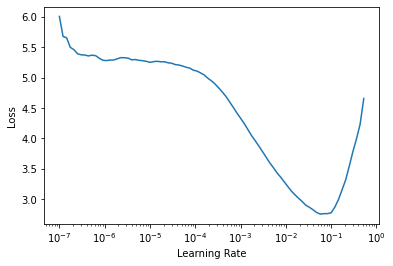

In [9]:
# Find an optimal learning rate
learn = cnn_learner(dls, resnet101, metrics=error_rate).to_fp16()

lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,error_rate,time
0,0.834604,1.713672,0.329499,01:13
1,0.532555,0.697680,0.184032,01:13
2,0.289255,0.531702,0.140731,01:13


Minimum/10: 7.59e-06, steepest point: 7.59e-07


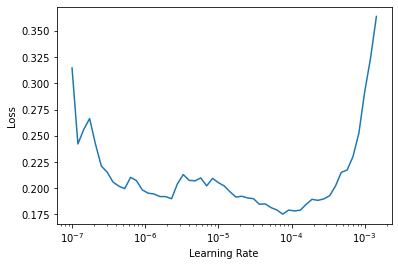

In [10]:
# Let's try near the min point
learn.fit_one_cycle(3, lr_max=5.0e-3)

learn.unfreeze()

lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [11]:
learn.fit_one_cycle(8, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.211008,0.467661,0.124493,01:29
1,0.193851,0.526002,0.133288,01:29
2,0.155265,0.398708,0.106225,01:29
3,0.116035,0.411680,0.107578,01:29
4,0.076599,0.365014,0.087957,01:29
5,0.050371,0.375754,0.089986,01:29
6,0.042115,0.375544,0.092016,01:29
7,0.034673,0.365732,0.092016,01:29


In [13]:
# Plot loss function
# learn.recorder.plot_metrics()

Well, that didn't help anything...  Let's go back to a basic RESNET101 w/ 5 epochs of training

## **Class Activation Map**

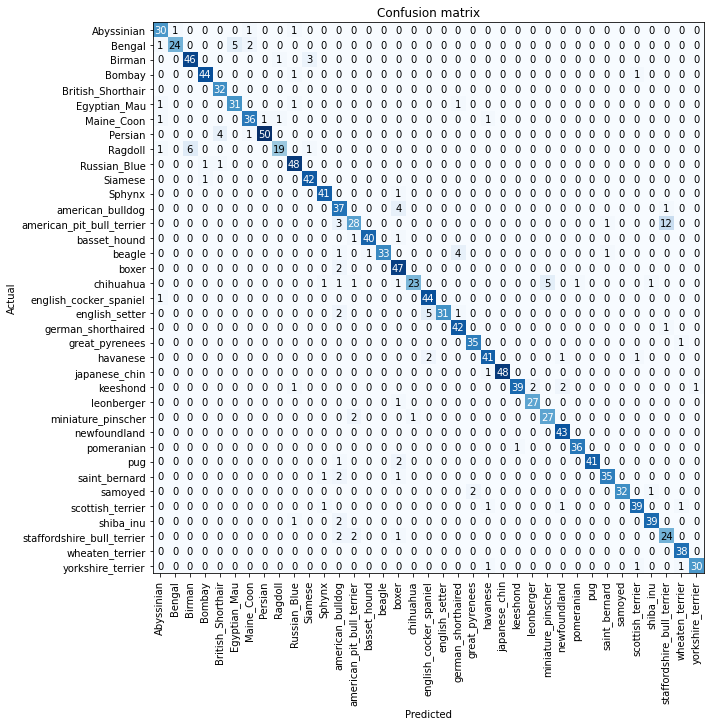

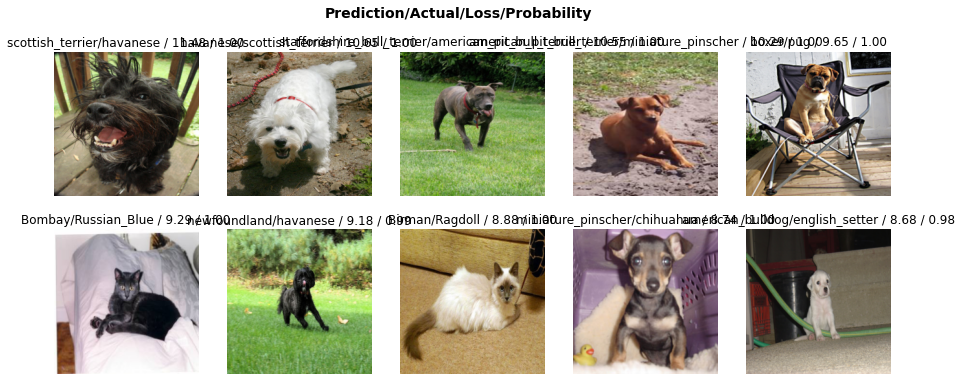

In [15]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.most_confused(min_val=5)
interp.plot_top_losses(10, nrows=2)

In [17]:
# Define Class Activation Map Hooks
# NEED TO FIX THIS FOR 37 CLASSES INSTEAD OF JUST 2.....

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
        
# Make a helper plot_gradcam() function to call on multiple images
def plot_gradcam(x, learn, hooked_layer, size=224):
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)
    x_img = TensorImage(dls.train.decode((x,))[0][0])
    
    for cls, ax in zip([-1, 0, 1], axes):
        if cls == -1:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookBwd(hooked_layer) as hookg:
            with Hook(hooked_layer) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size, 0),
            interpolation='bicubic', cmap='inferno'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))
    
    

**Let's take a look at the top losses**

Test File: havanese_128.jpg Predict: ('scottish_terrier', tensor(32), tensor([2.5790e-12, 1.7662e-10, 9.4103e-09, 7.5847e-08, 1.3621e-10, 1.6952e-10,
        2.2066e-10, 1.9664e-10, 2.7945e-11, 4.1318e-08, 6.4739e-09, 4.0788e-09,
        6.9785e-10, 7.0538e-10, 4.9824e-10, 6.0073e-13, 9.3371e-09, 1.9209e-10,
        3.4935e-07, 5.6450e-11, 4.0904e-10, 4.1548e-10, 1.0130e-05, 1.5863e-10,
        2.8067e-08, 4.9727e-10, 7.1859e-10, 2.2644e-07, 1.2997e-10, 1.0568e-09,
        3.5188e-11, 2.3658e-08, 9.9999e-01, 1.0858e-11, 4.6637e-08, 3.2759e-06,
        3.2210e-08]))


ValueError: too many values to unpack (expected 2)

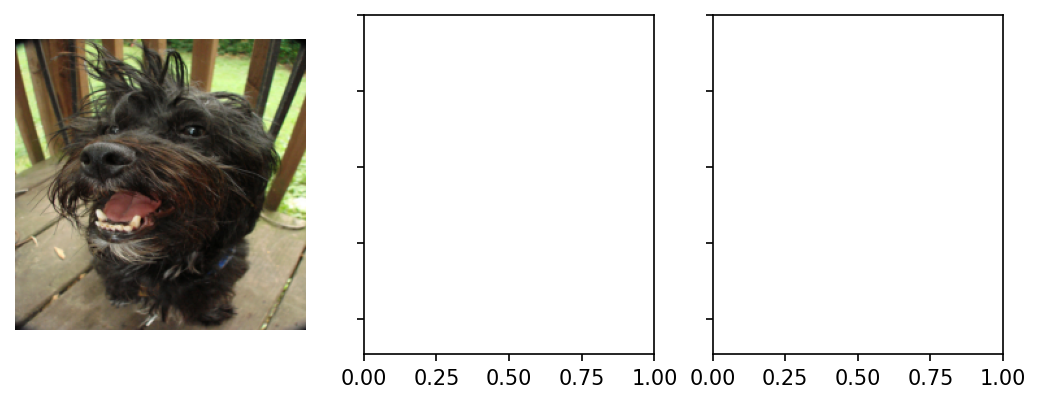

In [18]:
losses,idxs = interp.top_losses(5)
for idx in idxs:
    f = dls.valid_ds.items[idx]
    img = PILImage.create(f)
    x, = first(dls.test_dl([img]))
    print(f"Test File: {os.path.basename(f)} Predict: {learn.predict(img)}")
    plot_gradcam(x, learn, learn.model[0])
    